# General

In [1]:
# run.py
import numpy as np
import matplotlib.pyplot as plt 
from proj1_helpers import *

In [2]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis = 0)
    x = x - mean_x
    std_x = np.std(x, axis = 0)
    x = x / std_x
    return x, mean_x, std_x

def de_standardize(x, mean_x, std_x):
    """Reverse the procedure of standardization."""
    x = x * std_x
    x = x + mean_x
    return x

def build_poly(x, degree, offset=True):
    """Polynomial basis functions for input data x,
    for up to a certain degree."""
    if offset:
        rows, cols = np.indices((x.shape[0], degree+1))
        tx = np.power(x[rows], cols)
    else:
        rows, cols = np.indices((x.shape[0], degree))
        tx = np.power(x[rows], cols+1)
    return tx

def build_model_data(x, y):
    """Form (y,tX) to get regression data in matrix form. Uses build_poly."""
    tx = np.c_[np.ones(len(y)), x]
    return y, tx

def split_data(x, y, ratio):
    """Split the dataset based on the split ratio.

    E.g. if the ratio is 0.8 then 80% of the data set is dedicated
    to training (and the rest dedicated to testing)
    """
    size = int(ratio * x.shape[0])
    indices = np.random.permutation(x.shape[0])
    training_idx, test_idx = indices[:size], indices[size:]

    x_training, x_test = x[training_idx], x[test_idx]
    y_training, y_test = y[training_idx], y[test_idx]

    return x_training, x_test, y_training, y_test

def compute_mse(y, tx, w):
    """Calculates the loss using MSE."""
    if len(tx.shape) == 1:
        tx = tx.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    w = np.array(w).reshape(tx.shape[1], 1)
    z = y - tx.dot(w)
    z = z.T.dot(z)
    return z[0][0] / tx.shape[0]

def sigmoid(t):
    """Apply sigmoid function on t, with t being a one dim vector"""
    t_exp = np.exp(t)
    return t_exp / (t_exp + 1)

In [3]:
def calculate_precision(y, y_pred):
    correct = np.sum(np.abs(y + y_pred))/2
    precision = correct / y.shape[0]
    return precision

In [4]:
DATA_PATH = '../data/'

#### Random seed

In [5]:
np.random.seed(1)

#### Read files and prepare data

In [6]:
yb, input_data, ids = load_csv_data(DATA_PATH+'train.csv')

In [7]:
test_yb, test_input_data, test_ids = load_csv_data(DATA_PATH+'test.csv')

#### In case we need to change the labels (we now need to do it for logistic regression)

In [8]:
#y = np.ones(len(yb))
#y[np.where(yb==-1)] = 0
y = yb

#### Normalize and add offset

In [9]:
x, mean_x, std_x = standardize(input_data)
y, tx = build_model_data(x, y)

In [10]:
test_x, test_mean_x, test_std_x = standardize(test_input_data)
test_y, test_tx = build_model_data(test_x, test_yb)

# 70% split and Ridge regression

In [ ]:
tx_training, tx_val, y_training, y_val = split_data(tx, y, .7)

In [11]:
def ridge_regression(y, tx, lambda_):
    """Implements ridge regression using normal equations."""
    # create identity matrix
    I = np.eye(tx.shape[1])
    # compute w opt using normal equations
    inv = np.linalg.inv(tx.T.dot(tx) + 2 * tx.shape[1] * lambda_ * I)
    w_opt = inv.dot(tx.T).dot(y)
    # compute ridge regression loss
    loss = compute_mse(y, tx, w_opt) + lambda_ / tx.shape[1] * w_opt.T.dot(w_opt)
    return w_opt, loss

In [ ]:
lambdas = np.logspace(-3, 2, num=18)

In [ ]:
precisions_tr = []
precisions_te = []
ws = []

for lambda_ in lambdas:
    w_opt, loss = ridge_regression(y, tx, lambda_)
    y_pred_tr = predict_labels(w_opt, tx_training)
    y_pred_te = predict_labels(w_opt, tx_val)
    precision_tr = calculate_precision(y_training, y_pred_tr)
    precision_te = calculate_precision(y_val, y_pred_te)
    ws.append(w_opt)
    precisions_tr.append(precision_tr)
    precisions_te.append(precision_te)

In [ ]:
plt.semilogx(lambdas, precisions_te)
plt.semilogx(lambdas, precisions_tr)
plt.show()

We can choose $\lambda=10^{-2}$

In [ ]:
w_opt, loss = ridge_regression(y, tx, 10**(-2))
test_y_pred = predict_labels(w_opt, test_tx)

In [ ]:
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'ridge_submission.csv')

We get 0.74454

# 70% split and SGD Logistic Regression

In [11]:
tx_training, tx_val, y_training, y_val = split_data(tx, y, .7)

In [12]:
def get_batch(y, tx, batch_size):
    m = tx.shape[0]
    p = np.random.permutation(np.arange(m))
    tx_p, y_p = tx[p], y[p]
    return y_p[:batch_size], tx_p[:batch_size,:]

In [13]:
def log_regr_by_gradient_descent(y, tx, w, gamma):
    """Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    tx_w = tx.dot(w)
    # compute the cost
    loss = np.sum(np.log(1 + np.exp(tx_w))) - np.sum(y * tx_w)
    # compute the gradient
    gradient = tx.T.dot(sigmoid(tx_w) - y)
    # update w
    w_1 = w
    w = w_1 - gamma * gradient
    return loss, w

In [14]:
def logistic_regression(y, tx, initial_w, max_iters, gamma, return_all=False):
    """Logistic regression using mini-batch gradient descent"""
    if len(tx.shape) == 1:
        tx = tx.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    initial_w = np.array(initial_w).reshape(tx.shape[1], 1)

    batch_size = int(.1 * tx.shape[0])
    
    # init parameters    
    w = initial_w
    if return_all:
        ws = [w]
        losses = []

    for n_iter in range(max_iters):
        gamma_iter = gamma / ((n_iter + 1)**2)
        # get mini-batch
        y_n, tx_n = get_batch(y, tx, batch_size)
        # get loss and update w by gradient
        loss, w = log_regr_by_gradient_descent(y_n, tx_n, w, gamma_iter)
        if return_all:
            # store w and loss
            ws.append(w)
            losses.append(loss)
            if n_iter % 100 == 0:
                print("Current iteration={i}, loss={l}".format(i=n_iter, l=loss))
    # return w and loss, either all or only last ones
    if return_all:
        return ws, losses
    else:
        return w, loss

In [15]:
initial_w = np.zeros((tx_training.shape[1], 1))
max_iters = 10000
gamma = .00001
w, loss = logistic_regression(y_training, tx_training, initial_w, max_iters, gamma, return_all=False)

In [16]:
def predict_labels_bis(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1

    return y_pred

In [46]:
y_pred_te = predict_labels_bis(w, tx_val)
y_aux = np.ones(len(y_pred_te))
y_aux[np.where(y_pred_te==0)[0]] = -1

In [47]:
precision_te = calculate_precision(y_aux, y_pred_te.flatten())

In [48]:
precision_te

0.017453333333333335

In [ ]:
test_y_pred = predict_labels_bis(w_opt, test_tx)

# Others

Use gradient descent:

Ridge regression using k-fold

In [12]:
def build_k_indices(y, k_fold, seed):
    '''
    Build k indices for k-fold.
    '''
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def split_data_k_indices(y, x, k_indices, k):
    '''
    Splits the data into test and training data.
    Samples get randomized through 'k_indices' and
    selected through 'k'.
    '''
    mask = np.ones(k_indices.shape, dtype=bool)
    mask[k] = False
    
    # Test data
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    
    # Train data
    x_train = x[k_indices[mask]]
    y_train = y[k_indices[mask]]
    
    return x_test, y_test, x_train, y_train

In [13]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    '''
    Return the loss of ridge regression.
    '''
    # Split data according to 'k_indices' and 'k'
    x_test, y_test, x_train, y_train = split_data_k_indices(y, x, k_indices, k)

    # Form data with polynomial degree
    # tx_test = build_poly(x_test, degree)
    # tx_train = build_poly(x_train, degree)

    # Apply ridge regression
    w_opt, rmse_train = ridge_regression(y_train, x_train, lambda_)
    
    prediction = {
        'train': predict_labels(w_opt, x_train),
        'test': predict_labels(w_opt, x_test)
    } 
    
    precision = {
        'train': calculate_precision(prediction['train'], y_train),
        'test': calculate_precision(prediction['test'], y_test)
    }
    
    # Return loss for train and test data
    return precision['train'], precision['test']

In [14]:
def cross_validation_visualization(lambds, mse_tr, mse_te, mse_dif):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.semilogx(lambds, mse_dif, marker=".", color='y', label='error delta')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.71703886815547258, 0.71826287305149217]
[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.71703886815547258, 0.71826287305149217]
[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.71703886815547258, 0.71826287305149217]
[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.71703886815547258, 0.71826287305149217]
[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.71703886815547258, 0.71826287305149217]
[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.71703886815547258, 0.71826287305149217]
[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.71703886815547258, 0.71826287305149217]
[0.71779487117948471, 0.71904287617150464, 0.71858087432349727]
[0.72036288145152583, 0.7170388681554725

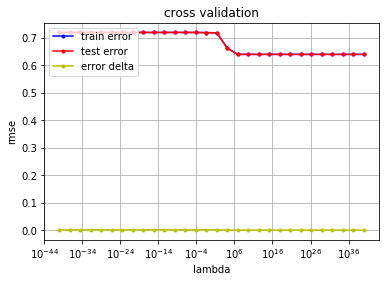

In [17]:
degree = 7
k_fold = 3
seed = 13

lambdas = np.logspace(-40, 40, 30)

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)

lambda_avg_rmse_trs = []
lambda_avg_rmse_tes = []
lambda_avg_rmse_difs = []

for lambda_ in lambdas:
    
    rmse_trs = []
    rmse_tes = []
    rmse_difs = []

    # K-fold cross validation and pick the rmse 'test' and 'train'
    # errors that represent the least absolute difference between
    # them (for a given lambda).
    for k in range(k_fold):
        rmse_cur_tr, rmse_cur_te = cross_validation(y, x, k_indices, k, lambda_, degree)
        
        rmse_trs.append(rmse_cur_tr)
        rmse_tes.append(rmse_cur_te)
        rmse_difs.append(abs(rmse_cur_tr - rmse_cur_te))
        
    lambda_avg_rmse_trs.append(np.mean(rmse_trs))
    lambda_avg_rmse_tes.append(np.mean(rmse_tes))
    lambda_avg_rmse_difs.append(np.mean(rmse_difs))

cross_validation_visualization(lambdas, lambda_avg_rmse_trs, lambda_avg_rmse_tes, lambda_avg_rmse_difs)

Read test data

In [ ]:
test_yb, test_input_data, test_ids = load_csv_data(DATA_PATH+'test.csv')

Predict labels:

In [ ]:
test_y_pred = predict_labels(w_opt, test_input_data)

Create submission:

In [ ]:
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'submission.csv')